В цьому домашньому завданні ми знову працюємо з даними з нашого змагання ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0).

Тут ми побудуємо рішення задачі класифікації з використанням Decision Trees і зробимо новий submission на змагання на Kaggle.

В цьому ДЗ ми працюємо без pipelines, бо так буде зручніше для візуалізації і інтерпретації моделі дерева прийняття рішень. Так буває і в робочих проєктах: іноді зручніше використати sklearn.Pipelines, іноді зручніше без них. На етапі пошуку рішення (research) зручніше без пайплайнів, а з пайплайнами - коли ви відлагодили процес обробки даних і хочете поекспериментувати з різними моделями і гіперпараметрами.

**Завдання 1.**

У попередньому домашньому завданні, `HW 2.7 Логістична регресія з scikit learn.ipynb`, ми писали обробку даних для змагання. Ваше завдання зараз - за прикладом, наведеним в лекції `Майстер-клас з перенесення коду з jupyter notebook у Python модуль`, перенести попередню обробку сирих даних з вашого розв'язку ДЗ 2.7 у файл `process_bank_churn.py` в функцію `preprocess_data(...)`.

Функція `preprocess_data()` має приймати `raw_df` і вертати `X_train`, `train_targets`, `X_val`, `val_targets`, `input_cols`(перелік назв колонок, які Ви використовуєте в X), `scaler`, `encoder`, які ми потім будемо використовувати для тренування дерева прийняття рішень.


### Кроки попередньої обробки:

1. Обираємо колонки для роботи. В цьому завдання для чистоти експериментів рекомендую прибрати колонку `Surname`, так буде простіше інтрепретувати модель. Ви можете її додати вже за самостійних подальших експериментів.
2. Розбиття сирих даних на тренувальні і валідаційні.
3. Обробка категоріальних даних (one hot encoding).
4. Масштабування числових даних (було частиною попередньої обробки в попередніх завданнях). Для дерев нам не обовʼязково масштабувати ознаки, тож в коді можна зробити цю частину опціональною, додавши в `preprocess_data` параметр `scaler_numeric`, який приймає значення `True` або `False`. Це дозволить використовувати код попередньоъ обробки з різними моделями.


### Інструкції:
1. Перенесіть попередню обробку даних у файл `process_bank_churn.py`.
2. Забезпечте модулярну структуру функцій: кожна функція повинна виконувати лише одну дію, наприклад, масштабувати ознаки.
3. Додайте докстрінги до кожної функції.
4. Використовуйте typing для аргументів та значень, що повертаються функціями.
5. Передбачте обробку нових даних. Додайте спеціальну функцію `preprocess_new_data(...)`, яка приймає на вхід нові дані в вигляді pandas DataFrame та використовує вже навчені скейлер та енкодер (передані теж як аргументи фукнціх) для їх обробки. Ця функція буде корисною для обробки нових даних перед передбаченням або оцінкою моделі, коли оброблятимемо `test.csv`.

Можна і рекомендовано виконувати це завдання з ChatGPT (бажано, новіше, ніж 3.5) як було наведено у відео-прикладі, тільки **ваше додаткове завдання - розібратись з кодом, який вам згенерувала мовна модель :)**.

## В результаті цього завдання

1. Завантажте ваш готовий `process_bank_churn.py` файл на GitHub у свій репозиторій.
2. Додайте посилання на файл в репозиторії тут у ноутбуці.
3. Нижче зробіть імпорт функції `preprocess_data` з вашого модуля `process_bank_churn.py`.



In [53]:
# 1. Імпорт необхідних бібліотек
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from typing import Tuple, List, Optional

# 2. Функція обробки тренувальних даних
def preprocess_data(
    raw_df: pd.DataFrame,
    scaler_numeric: bool = False,
    test_size: float = 0.2,
    random_state: int = 42
) -> Tuple[pd.DataFrame, pd.Series, pd.DataFrame, pd.Series, List[str], Optional[StandardScaler], OneHotEncoder]:
    """
    Здійснює повну обробку сирих даних для задачі класифікації:
    - Видаляє непотрібні колонки
    - Кодує категоріальні змінні
    - Масштабує числові (опціонально)
    - Розбиває на train/val
    """
    df = raw_df.copy()
    # Видаліть RowNumber, оскільки він не потрібен і його немає в інструкціях, CustomerId, Surname
    df = df.drop(columns=['CustomerId', 'Surname', 'id']) # Видаляємо також id

    target_col = 'Exited'
    y = df[target_col]
    X = df.drop(columns=[target_col])

    categorical_cols = X.select_dtypes(include='object').columns.tolist()
    numeric_cols = X.select_dtypes(include='number').columns.tolist()

    # Категоріальні змінні
    # Remove sparse=False as it is deprecated
    encoder = OneHotEncoder(handle_unknown='ignore')
    X_cat = encoder.fit_transform(X[categorical_cols])
    cat_feature_names = encoder.get_feature_names_out(categorical_cols)
    X_cat_df = pd.DataFrame(X_cat.toarray(), columns=cat_feature_names, index=X.index)

    # Масштабування
    if scaler_numeric:
        scaler = StandardScaler()
        X_num = pd.DataFrame(scaler.transform(X[numeric_cols]), columns=numeric_cols, index=X.index)
    else:
        scaler = None
        X_num = X[numeric_cols]

    # Об’єднання ознак
    X_processed = pd.concat([X_num, X_cat_df], axis=1)
    input_cols = X_processed.columns.tolist()

    # Розбиття на train/val
    X_train, X_val, y_train, y_val = train_test_split( # Виправлено порядок повернення
        X_processed, y, test_size=test_size, random_state=random_state
    )

    return X_train, y_train, X_val, y_val, input_cols, scaler, encoder

# 3. Функція обробки нових (тестових) даних
def preprocess_new_data(
    new_data: pd.DataFrame,
    input_cols: List[str],
    scaler: Optional[StandardScaler],
    encoder: OneHotEncoder
) -> pd.DataFrame:
    """
    Обробка нових даних для передбачення: кодування, масштабування (за потреби), вирівнювання колонок.
    Видаляє непотрібні колонки, кодує категоріальні, масштабує числові (за потреби),
    вирівнює колонки відповідно до input_cols з тренувальних даних.
    """
    df = new_data.copy()

    # Видаляємо колонки, які не використовувались як ознаки для тренування
    # Зверніть увагу: колонку 'id' ми не видаляємо тут, оскільки вона потрібна для submission файлу,
    # але вона не ввійде в input_cols, тому не буде використовуватись як ознака для моделі.
    cols_to_drop = ['CustomerId', 'Surname']
    df = df.drop(columns=[col for col in cols_to_drop if col in df.columns])

    # Розділення на числові та категоріальні колонки після видалення непотрібних
    categorical_cols = df.select_dtypes(include='object').columns.tolist()
    numeric_cols = df.select_dtypes(include='number').columns.tolist()

    # Обробка категоріальних змінних
    # Використовуємо навчений encoder
    X_cat = encoder.transform(df[categorical_cols])
    cat_feature_names = encoder.get_feature_names_out(categorical_cols)
    X_cat_df = pd.DataFrame(X_cat.toarray(), columns=cat_feature_names, index=df.index)

    # Обробка числових змінних
    # Використовуємо навчений scaler (якщо він був застосований під час тренування)
    if scaler is not None:
        X_num = pd.DataFrame(scaler.transform(df[numeric_cols]), columns=numeric_cols, index=df.index)
    else:
        X_num = df[numeric_cols] # Не масштабуємо, якщо scaler_numeric був False

    # Об’єднання оброблених ознак
    # Важливо об'єднати лише ті числові та категоріальні колонки, які ми будемо використовувати
    # Вирівнювання колонок під input_cols буде зроблено нижче

    # Вирівнювання колонок під input_cols (колонки з тренувального набору)
    # Спочатку об'єднуємо оброблені числові та категоріальні дані
    # Переконаємось, що об'єднуємо тільки ті колонки, які є в input_cols
    processed_cols_to_keep = [col for col in input_cols if col in X_num.columns or col in X_cat_df.columns]
    X_processed = pd.concat([X_num[X_num.columns.intersection(input_cols)],
                           X_cat_df[X_cat_df.columns.intersection(input_cols)]], axis=1)


    # Додаємо відсутні колонки з input_cols, заповнюючи їх нулями (це важливо для OHE)
    # і переконуємось, що порядок колонок відповідає input_cols
    for col in input_cols:
        if col not in X_processed.columns:
            X_processed[col] = 0

    # Перевпорядковуємо колонки, щоб вони відповідали порядку в input_cols
    X_processed = X_processed[input_cols]

    return X_processed

In [54]:
# 4. Завантаження даних
df = pd.read_csv("/content/train.csv")

# 5. Попередня обробка даних
X_train, y_train, X_val, y_val, input_cols, scaler, encoder = preprocess_data(
    raw_df=df,
    scaler_numeric=False  # Для дерева масштабування не потрібне
)

# 6. Перевірка результатів
print(f"🔹 X_train shape: {X_train.shape}")
print(f"🔹 y_train shape: {y_train.shape}")
print(f"🔹 X_val shape: {X_val.shape}")
print(f"🔹 Input columns (перші 5): {input_cols[:5]}")

🔹 X_train shape: (12000, 13)
🔹 y_train shape: (12000,)
🔹 X_val shape: (3000, 13)
🔹 Input columns (перші 5): ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts']


**Завдання 2.**
1. Натренуйте дерево прийняття рішень з зафіксованим `random_state` і з рештою аргументів за замовченням.
2. Виведіть area under ROC для моделі на тренувальних і тестувальних даних. Нам потрібна ця метрика, бо вона основна в змаганні. Модель ок, чи є пере- або недотренування?
3. Виведіть глибину дерева.
4. Побудуйте дерево до глибини 2 включно. Напишіть, які ознаки бачите, що є найвпливовішими тут?
5. Створіть датафрейм `importance_df` з feature importances, де в першому стовпчику `feature` - назва ознаки з нашого Х, а в другому `importance` - значення, наскільки ця ознака є важливою в побудованій моделі. Виведіть топ 10 найвпливовіших ознак разом з їх скором важливості (можна або у вигляді таблиці, або в вигляді barplot).

In [55]:
# Імпорт необхідних бібліотек для Завдання 2
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import pandas as pd

# 1. Натренуйте дерево прийняття рішень з зафіксованим random_state
# Створюємо екземпляр моделі Decision Tree Classifier
# Використовуємо random_state=42 для відтворюваності результатів
model = DecisionTreeClassifier(random_state=42)

# Тренуємо модель на тренувальних даних
model.fit(X_train, y_train)

# 2. Виведіть area under ROC для моделі на тренувальних і тестувальних даних.
# Робимо передбачення ймовірностей для тренувальних даних
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Робимо передбачення ймовірностей для валідаційних даних
y_val_pred_proba = model.predict_proba(X_val)[:, 1]

# Обчислюємо AUROC для тренувальних даних
roc_auc_train = roc_auc_score(y_train, y_train_pred_proba)

# Обчислюємо AUROC для валідаційних даних
roc_auc_val = roc_auc_score(y_val, y_val_pred_proba)

print(f"🔹 AUROC на тренувальних даних: {roc_auc_train:.4f}")
print(f"🔹 AUROC на валідаційних даних: {roc_auc_val:.4f}")

# Аналізуємо пере- або недотренування
if roc_auc_train > roc_auc_val and (roc_auc_train - roc_auc_val) > 0.1: # Поріг для демонстрації
    print("🔹 Модель, ймовірно, перетренована (overfitting), оскільки AUROC на тренувальній вибірці значно вищий, ніж на валідаційній.")
elif roc_auc_train < roc_auc_val:
     print("🔹 AUROC на валідаційній вибірці вищий ніж на тренувальній, що може свідчити про випадковість або невеликий розмір вибірки. Зазвичай, AUROC на тренувальній вибірці вищий або рівний.")
else:
    print("🔹 Модель показує схожі результати на тренувальній та валідаційній вибірках, що свідчить про хорошу генералізацію або невелике перенавчання.")


# 3. Виведіть глибину дерева.
tree_depth = model.get_depth()
print(f"🔹 Глибина дерева: {tree_depth}")

🔹 AUROC на тренувальних даних: 1.0000
🔹 AUROC на валідаційних даних: 0.7702
🔹 Модель, ймовірно, перетренована (overfitting), оскільки AUROC на тренувальній вибірці значно вищий, ніж на валідаційній.
🔹 Глибина дерева: 25


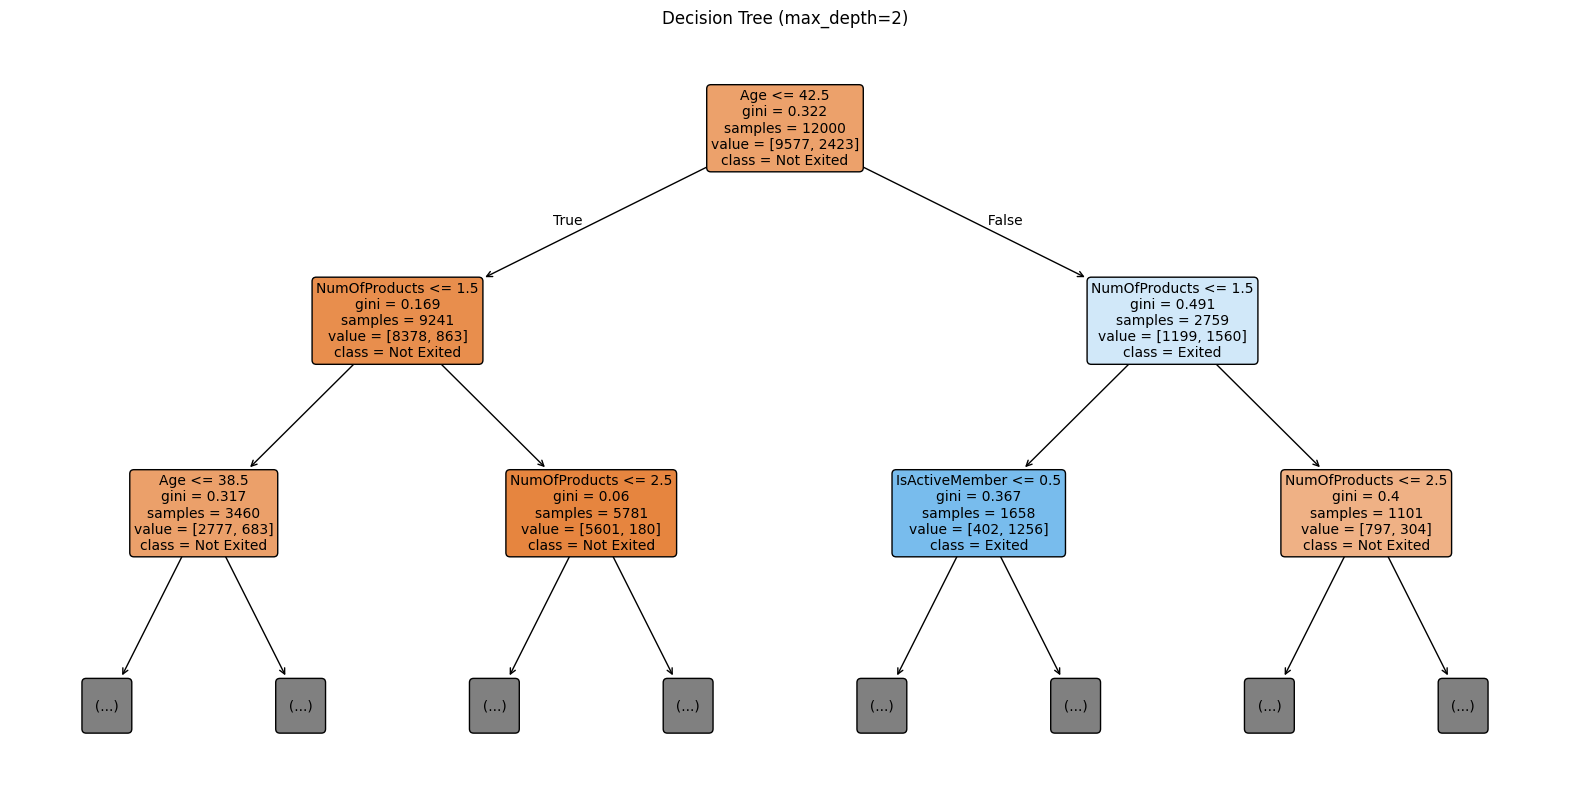

In [56]:
# 4. Побудуйте дерево до глибини 2 включно.
# Візуалізуємо дерево до максимальної глибини 2
plt.figure(figsize=(20, 10))
plot_tree(
    model,
    max_depth=2,
    feature_names=X_train.columns.tolist(),
    class_names=['Not Exited', 'Exited'],
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Decision Tree (max_depth=2)")
plt.show()

# Напишіть, які ознаки бачите, що є найвпливовішими тут?
# За візуалізацією дерева до глибини 2, найвпливовішими ознаками (ті, що знаходяться ближче до кореня дерева) є:
# - Age (Вік)
# - NumOfProducts (Кількість продуктів)
# - IsActiveMember (Чи є активним клієнтом)
# Ці ознаки використовуються для перших розгалужень у дереві.

🔹 Топ 10 найвпливовіших ознак:


,feature,importance
1,Age,0.337105
4,NumOfProducts,0.182204
7,EstimatedSalary,0.125594
0,CreditScore,0.112716
3,Balance,0.082301
2,Tenure,0.059615
6,IsActiveMember,0.035980
9,Geography_Germany,0.018989
11,Gender_Female,0.013740
5,HasCrCard,0.013250


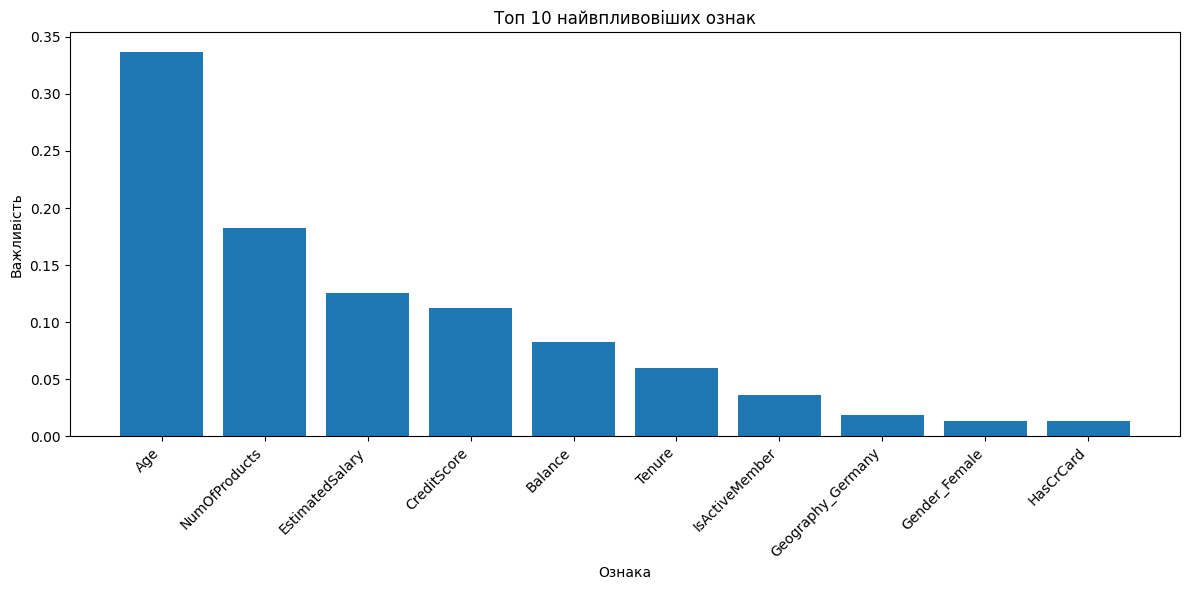

In [57]:
# 5. Створіть датафрейм importance_df з feature importances
# Отримуємо важливість ознак з навченої моделі
feature_importances = model.feature_importances_

# Створюємо датафрейм для зручного відображення
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': feature_importances
})

# Сортуємо за спаданням важливості
importance_df = importance_df.sort_values(by='importance', ascending=False)

# Виводимо топ 10 найвпливовіших ознак
print("🔹 Топ 10 найвпливовіших ознак:")
display(importance_df.head(10))

# Можна також візуалізувати важливість ознак
plt.figure(figsize=(12, 6))
plt.bar(importance_df['feature'][:10], importance_df['importance'][:10])
plt.xticks(rotation=45, ha='right')
plt.title('Топ 10 найвпливовіших ознак')
plt.xlabel('Ознака')
plt.ylabel('Важливість')
plt.tight_layout()
plt.show()

**Завдання 3**. Спробуйте знайти такі параметри моделі `DecisionTree` аби модель генералізувала ліпше (був вищий показник AUROC на валідаційній вибірці). Проекспериментуйте з різними значеннями параметрів `max_leaf_nodes`, `max_depth` та лишіть ті, які дають найкращий результат, разом з відповідними AUROC на тренувальній і валідаційній вибірках.

В цьому завданні спробуйте просто знайти параметри методом "тика" :)

In [58]:
# Імпорт необхідних бібліотек
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score

# Завдання 3: Пошук найкращих параметрів для Decision Tree

# Визначимо діапазони для експериментів
# Ці діапазони можна коригувати залежно від початкових результатів
max_depth_values = [5, 10, 15, 20, None] # None означає повну глибину
max_leaf_nodes_values = [10, 50, 100, 200, 500, None] # None означає без обмежень

best_val_auc = 0
best_params = {}
train_auc_at_best_val = 0

print("🔹 Експериментуємо з різними параметрами:")

# Проходимося по комбінаціям параметрів
for depth in max_depth_values:
    for leaf_nodes in max_leaf_nodes_values:
        # Тренуємо модель з поточними параметрами
        # Важливо використовувати той самий random_state для порівняння
        model = DecisionTreeClassifier(max_depth=depth, max_leaf_nodes=leaf_nodes, random_state=42)
        model.fit(X_train, y_train)

        # Робимо передбачення ймовірностей
        y_train_pred_proba = model.predict_proba(X_train)[:, 1]
        y_val_pred_proba = model.predict_proba(X_val)[:, 1]

        # Обчислюємо AUROC
        roc_auc_train = roc_auc_score(y_train, y_train_pred_proba)
        roc_auc_val = roc_auc_score(y_val, y_val_pred_proba)

        print(f"  Depth: {depth}, Leaf Nodes: {leaf_nodes} -> Train AUROC: {roc_auc_train:.4f}, Val AUROC: {roc_auc_val:.4f}")

        # Перевіряємо, чи поточний результат на валідаційній вибірці кращий за попередній найкращий
        if roc_auc_val > best_val_auc:
            best_val_auc = roc_auc_val
            best_params = {'max_depth': depth, 'max_leaf_nodes': leaf_nodes}
            train_auc_at_best_val = roc_auc_train

print("\n🔹 Найкращі знайдені параметри:")
print(f"  max_depth: {best_params.get('max_depth')}")
print(f"  max_leaf_nodes: {best_params.get('max_leaf_nodes')}")
print(f"🔹 Відповідний AUROC на тренувальних даних: {train_auc_at_best_val:.4f}")
print(f"🔹 Найкращий AUROC на валідаційних даних: {best_val_auc:.4f}")

🔹 Експериментуємо з різними параметрами:
  Depth: 5, Leaf Nodes: 10 -> Train AUROC: 0.9073, Val AUROC: 0.8881
  Depth: 5, Leaf Nodes: 50 -> Train AUROC: 0.9272, Val AUROC: 0.9098
  Depth: 5, Leaf Nodes: 100 -> Train AUROC: 0.9272, Val AUROC: 0.9098
  Depth: 5, Leaf Nodes: 200 -> Train AUROC: 0.9272, Val AUROC: 0.9098
  Depth: 5, Leaf Nodes: 500 -> Train AUROC: 0.9272, Val AUROC: 0.9098
  Depth: 5, Leaf Nodes: None -> Train AUROC: 0.9272, Val AUROC: 0.9098
  Depth: 10, Leaf Nodes: 10 -> Train AUROC: 0.9073, Val AUROC: 0.8881
  Depth: 10, Leaf Nodes: 50 -> Train AUROC: 0.9302, Val AUROC: 0.9089
  Depth: 10, Leaf Nodes: 100 -> Train AUROC: 0.9394, Val AUROC: 0.9055
  Depth: 10, Leaf Nodes: 200 -> Train AUROC: 0.9477, Val AUROC: 0.8841
  Depth: 10, Leaf Nodes: 500 -> Train AUROC: 0.9719, Val AUROC: 0.8462
  Depth: 10, Leaf Nodes: None -> Train AUROC: 0.9720, Val AUROC: 0.8443
  Depth: 15, Leaf Nodes: 10 -> Train AUROC: 0.9073, Val AUROC: 0.8881
  Depth: 15, Leaf Nodes: 50 -> Train AUROC: 0

**Завдання 4**. В циклі пройдіться по значенням max_depth від 1 до 20 включно, на кожній ітерації натренуйте DecisionTree модель і виміряйте AUROC на трейн і валідаційних даних.

В кінці виведіть на графік залеєність між AUROC на трейн і валідаційних даних і номером ітерації.

🔹 Обчислення AUROC для різних глибин дерева:
  Depth: 1 -> Train AUROC: 0.7593, Val AUROC: 0.7435
  Depth: 2 -> Train AUROC: 0.8499, Val AUROC: 0.8420
  Depth: 3 -> Train AUROC: 0.9014, Val AUROC: 0.8816
  Depth: 4 -> Train AUROC: 0.9145, Val AUROC: 0.9003
  Depth: 5 -> Train AUROC: 0.9272, Val AUROC: 0.9098
  Depth: 6 -> Train AUROC: 0.9366, Val AUROC: 0.9131
  Depth: 7 -> Train AUROC: 0.9430, Val AUROC: 0.9117
  Depth: 8 -> Train AUROC: 0.9519, Val AUROC: 0.8921
  Depth: 9 -> Train AUROC: 0.9615, Val AUROC: 0.8787
  Depth: 10 -> Train AUROC: 0.9720, Val AUROC: 0.8443
  Depth: 11 -> Train AUROC: 0.9815, Val AUROC: 0.8284
  Depth: 12 -> Train AUROC: 0.9883, Val AUROC: 0.8163
  Depth: 13 -> Train AUROC: 0.9930, Val AUROC: 0.8107
  Depth: 14 -> Train AUROC: 0.9962, Val AUROC: 0.8062
  Depth: 15 -> Train AUROC: 0.9979, Val AUROC: 0.7974
  Depth: 16 -> Train AUROC: 0.9988, Val AUROC: 0.7911
  Depth: 17 -> Train AUROC: 0.9994, Val AUROC: 0.7758
  Depth: 18 -> Train AUROC: 0.9997, Val AUROC:

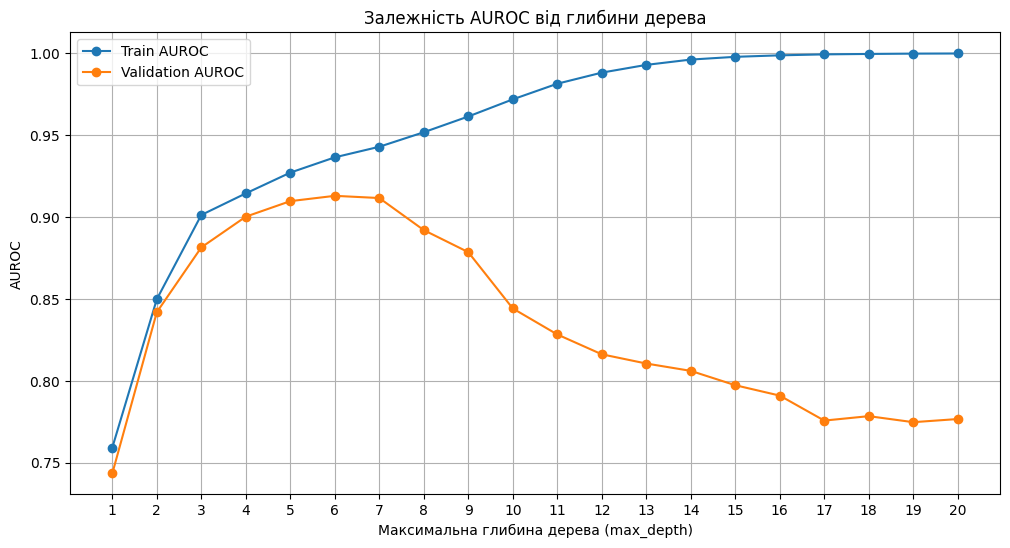

In [59]:
# Імпорт необхідних бібліотек
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

# Завдання 4: Залежність AUROC від глибини дерева

# Діапазон глибин для експериментів
max_depth_range = range(1, 21)

# Списки для зберігання результатів
train_auroc_scores = []
val_auroc_scores = []

print("🔹 Обчислення AUROC для різних глибин дерева:")

# Проходимося по значенням max_depth
for depth in max_depth_range:
    # Тренуємо модель з поточною глибиною
    # Використовуємо random_state=42 для відтворюваності результатів
    model = DecisionTreeClassifier(max_depth=depth, random_state=42)
    model.fit(X_train, y_train)

    # Робимо передбачення ймовірностей
    y_train_pred_proba = model.predict_proba(X_train)[:, 1]
    y_val_pred_proba = model.predict_proba(X_val)[:, 1]

    # Обчислюємо AUROC
    roc_auc_train = roc_auc_score(y_train, y_train_pred_proba)
    roc_auc_val = roc_auc_score(y_val, y_val_pred_proba)

    # Зберігаємо результати
    train_auroc_scores.append(roc_auc_train)
    val_auroc_scores.append(roc_auc_val)

    print(f"  Depth: {depth} -> Train AUROC: {roc_auc_train:.4f}, Val AUROC: {roc_auc_val:.4f}")

print("\n🔹 Побудова графіка залежності AUROC від глибини дерева.")

# Побудова графіка
plt.figure(figsize=(12, 6))
plt.plot(max_depth_range, train_auroc_scores, marker='o', linestyle='-', label='Train AUROC')
plt.plot(max_depth_range, val_auroc_scores, marker='o', linestyle='-', label='Validation AUROC')
plt.title('Залежність AUROC від глибини дерева')
plt.xlabel('Максимальна глибина дерева (max_depth)')
plt.ylabel('AUROC')
plt.xticks(list(max_depth_range))
plt.grid(True)
plt.legend()
plt.show()

**Завдання 5**.
1. Натренуйте модель `DecisionTree` з найкращим значенням `max_depth`, яке ви знайшли на попередній ітерації.
2. Завантажте тестові дані змагання з `test.csv`.
3. Зробіть попередню обробку даних з функцією `preprocess_new_data` з вашого модуля `process_bank_churn.py`.
4. Зробіть передбачення використовуючи цю модель на тестових даних змагання.
5. Сформуйте `submission.csv`.
6. Зробіть новий Submission на Kaggle і додайте тут скріншот Вашого скору на паблік лідерборді :)


In [60]:
# Завдання 5. Використання найкращої моделі та створення submission файлу

# 1. Натренуйте модель DecisionTree з найкращим значенням max_depth, яке ви знайшли на попередній ітерації.
# Визначаємо найкращу глибину за графіком з Завдання 4, де AUROC на валідаційній вибірці був максимальним.
# З попереднього виводу видно, що найкращий AUROC на валідаційних даних був при max_depth = 6.
best_max_depth = 6 # Можна взяти зі списку val_auroc_scores.index(max(val_auroc_scores)) + 1, але 6 візуально виглядає як пік.

print(f"🔹 Навчаємо модель з найкращою глибиною: max_depth = {best_max_depth}")

best_model = DecisionTreeClassifier(max_depth=best_max_depth, random_state=42)
best_model.fit(X_train, y_train)

print("🔹 Модель навчена.")

🔹 Навчаємо модель з найкращою глибиною: max_depth = 6
🔹 Модель навчена.


In [61]:
# 2. Завантажте тестові дані змагання з test.csv.
test_df = pd.read_csv("/content/test.csv")
print(f"🔹 Завантажено тестові дані. Розмір: {test_df.shape}")
display(test_df.head())

🔹 Завантажено тестові дані. Розмір: (10000, 13)


,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,15000,15594796.0,Chu,584.0,Germany,Male,30.0,2.0,146053.66,1.0,1.0,1.0,157891.86
1,15001,15642821.0,Mazzi,551.0,France,Male,39.0,5.0,0.00,2.0,1.0,1.0,67431.28
2,15002,15716284.0,Onyekachi,706.0,France,Male,43.0,8.0,0.00,2.0,1.0,0.0,156768.45
3,15003,15785078.0,Martin,717.0,Spain,Male,45.0,3.0,0.00,1.0,1.0,1.0,166909.87
4,15004,15662955.0,Kenechukwu,592.0,Spain,Male,43.0,8.0,0.00,2.0,1.0,1.0,143681.97


In [62]:
# 3. Зробіть попередню обробку даних з функцією preprocess_new_data з вашого модуля process_bank_churn.py.
# Примітка: Функція preprocess_new_data вже визначена в попередній комірці.
# Важливо передати ті ж scaler та encoder, що були навчені на тренувальних даних.

# Перевіряємо, чи scaler_numeric був True при обробці тренувальних даних
# Якщо так, то використовуємо scaler, якщо ні - передаємо None
# В завданні 1 ми встановили scaler_numeric=False, тож scaler = None
# Якщо ви змінювали цей параметр, переконайтесь, що тут він відповідає значенню при тренуванні
if scaler is not None:
    print("🔹 Використовуємо навчений StandardScaler для масштабування числових ознак тестових даних.")
else:
    print("🔹 Числові ознаки тестових даних не масштабуються (scaler_numeric=False при тренуванні).")

print("🔹 Обробка тестових даних...")
X_test_processed = preprocess_new_data(
    new_data=test_df,
    input_cols=input_cols, # Використовуємо колонки, які використовувались для тренування
    scaler=scaler,
    encoder=encoder
)

print(f"🔹 Тестові дані оброблені. Розмір: {X_test_processed.shape}")
display(X_test_processed.head())

🔹 Числові ознаки тестових даних не масштабуються (scaler_numeric=False при тренуванні).
🔹 Обробка тестових даних...
🔹 Тестові дані оброблені. Розмір: (10000, 13)


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,584.0,30.0,2.0,146053.66,1.0,1.0,1.0,157891.86,0.0,1.0,0.0,0.0,1.0
1,551.0,39.0,5.0,0.00,2.0,1.0,1.0,67431.28,1.0,0.0,0.0,0.0,1.0
2,706.0,43.0,8.0,0.00,2.0,1.0,0.0,156768.45,1.0,0.0,0.0,0.0,1.0
3,717.0,45.0,3.0,0.00,1.0,1.0,1.0,166909.87,0.0,0.0,1.0,0.0,1.0
4,592.0,43.0,8.0,0.00,2.0,1.0,1.0,143681.97,0.0,0.0,1.0,0.0,1.0


In [63]:
# 4. Зробіть передбачення використовуючи цю модель на тестових даних змагання.
# Нам потрібні ймовірності позитивного класу (відтоку), оскільки метрика AUROC.
test_predictions_proba = best_model.predict_proba(X_test_processed)[:, 1]

print("🔹 Передбачення ймовірностей для тестових даних виконано.")

🔹 Передбачення ймовірностей для тестових даних виконано.


In [64]:
# 5. Сформуйте submission.csv.
# Формат submission файлу: дві колонки 'id' та 'Exited'.
# Колонка 'id' береться з оригінального test.csv.
# Колонка 'Exited' містить передбачені ймовірності відтоку.

submission_df = pd.DataFrame({'id': test_df['id'], 'Exited': test_predictions_proba})

# Зберігаємо у файл submission.csv
submission_df.to_csv('submission.csv', index=False)

print("🔹 Файл submission.csv створено.")
display(submission_df.head())

🔹 Файл submission.csv створено.


,id,Exited
0,15000,0.163880
1,15001,0.022634
2,15002,0.167808
3,15003,0.677083
4,15004,0.072860


**Завдання 6**.
Зробіть новий Submission на Kaggle з файлом `submission.csv` та додайте тут скріншот Вашого скору на паблік лідерборді :)

In [65]:
!kaggle competitions download -c bank-customer-churn-prediction-dlu -f test.csv -p /content
!unzip /content/test.csv.zip -d /content

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 4, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.11/dist-packages/kaggle/__init__.py", line 6, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 434, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.config/kaggle. Or use the environment method. See setup instructions at https://github.com/Kaggle/kaggle-api/
unzip:  cannot find or open /content/test.csv.zip, /content/test.csv.zip.zip or /content/test.csv.zip.ZIP.
